In [14]:
"""
Filename: optgrowth.py
Authors: John Stachurski, Thomas Sargent

Solving the optimal growth problem via value function iteration.  The model is
described in 

    http://quant-econ.net/py/optgrowth.html
"""

import numpy as np
from scipy.optimize import fminbound


def bellman_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [15]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

In [16]:
lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

In [17]:
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

In [18]:
import numpy as np
import matplotlib.pyplot as plt

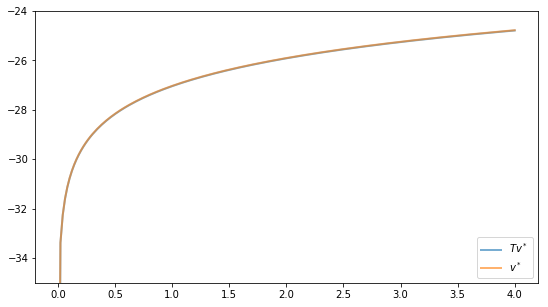

In [19]:
w = bellman_operator(v_star(grid),
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks)


fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid, w, lw=2, alpha=0.6, label=r'$Tv^*$')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='$v^*$')
ax.legend(loc='lower right')
plt.show()

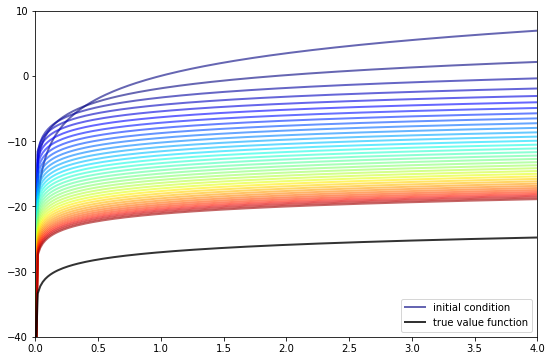

In [20]:
w = 5 * np.log(grid)  # An initial condition
n = 35
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, 10)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = bellman_operator(w,
                         grid,
                         beta,
                         np.log,
                         lambda k: k**alpha,
                         shocks)

    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right')

plt.show()

In [26]:
from quantecon import compute_fixed_point

Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

v_star_approx = compute_fixed_point(bellman_operator,
                                    initial_w,
                                    1e-5,  # error_tol
                                    1000,  # max_iter
                                    True,  # verbose
                                    5,     # print_skip
                                    'iteration',
                                    grid,
                                    beta,
                                    np.log,
                                    lambda k: k**alpha,
                                    shocks,
                                    Tw=Tw,
                                    compute_policy=False)

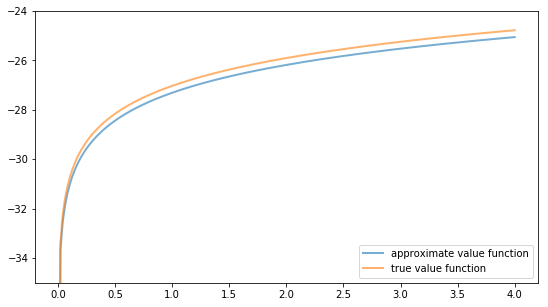

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc='lower right')
plt.show()